# GRAB SAFETY CHALLENGE

Below is the model that I found most suitable to meet the objectives of this challenge. I hope you enjoy my simple but effective solution.

## Goal
The goal is to create a model that can be used to detect dangerous driving trips. The model is going to be evaluated using the AUC-ROC curve.

## Features
This model uses the telematics data to varying degree with a total of 5 features added on.

## Model
The model uses stacking and boosting to improve the results of the model and to prevent overfitting.

## Performance
The model has a 0.74 AUC score. This score was taken from using XGBoost which produced the highest score. The stacked model was only slightly lower.

## Testing
Before you run the code, please uncomment the cells that impact Holdout. This version shows shows how it is used it was trained.

## Lets get started!

In [321]:
#Essential Imports
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

#Models
from vecstack import stacking
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as XGBClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier

#Others
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Holdout Data Import

Import Holdout testing data by changing the directory

In [322]:
# #Importing Hold out Data
# file_path ="safety/testing"
# files = glob.glob(os.path.join(file_path, '*.csv'))
# t_df = (pd.read_csv(c) for c in files)
#Joining the testing data
# test = pd.concat(df, ignore_index = True, sort=False)

Import Holdout data labels by changing the file path

In [323]:
#Importing Test Labels
# t_labels = pd.read_csv("safety/test_labels.csv")

In [324]:
# #Standadizing labels and test
# #Check IDs that appear >1
# t_temp = pd.crosstab(index = labels['bookingID'], columns = 'count')
# t_temp = temp[temp['count']!=1]

# #Dropping bookingIds with multiple labels
# t_drop = temp.index.values
# t_labels = labels[~labels['bookingID'].isin(drop)]

# Data Import

In [365]:
#Importing Training Data
file_path ="C:/Users/Andrew Mark/Desktop/safety/features"
files = glob.glob(os.path.join(file_path, '*.csv'))
df = (pd.read_csv(c) for c in files)

In [366]:
#Joining the training data
train = pd.concat(df, ignore_index = True, sort=False)

In [367]:
#Importing Labels
labels = pd.read_csv("C:/Users/Andrew Mark/Desktop/safety/labels/labels.csv")

# Data Cleaning and Exploration

In [368]:
# Let's view what data we are working with
train.sample(5)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
14467145,1606317768755,3.900,350.000000,-0.378284,7.848193,-2.580950,0.217334,0.393837,-0.122478,806.0,9.670000
1957070,1700807049304,6.807,84.000000,-0.057663,8.847626,0.811386,0.005798,0.039017,0.012695,310.0,3.390000
11478110,592705486890,32.000,2.473371,-0.622519,-9.474609,-2.611948,-0.020253,0.199595,-0.113104,235.0,7.218929
5654250,979252543506,3.000,0.000000,0.326813,10.019470,1.208145,-0.148847,0.051053,-0.003870,244.0,0.000000
5493176,1460288880755,3.000,176.000000,1.704672,7.354988,6.464345,-0.001833,0.031154,0.033598,36.0,1.010000


In [369]:
# Let's deep dive into our columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16135561 entries, 0 to 16135560
Data columns (total 11 columns):
bookingID         int64
Accuracy          float64
Bearing           float64
acceleration_x    float64
acceleration_y    float64
acceleration_z    float64
gyro_x            float64
gyro_y            float64
gyro_z            float64
second            float64
Speed             float64
dtypes: float64(10), int64(1)
memory usage: 1.3 GB


In [370]:
#Checking the data for missing values
train.isnull().sum().sum()

0

In [371]:
# Let's view the labels file
labels.sample(5)

,bookingID,label
4364,1013612281868,0
4013,180388626482,0
3691,1305670058012,0
3279,635655159832,1
19678,1314259992722,0


In [372]:
# Let's deep dive into our columns
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20018 entries, 0 to 20017
Data columns (total 2 columns):
bookingID    20018 non-null int64
label        20018 non-null int64
dtypes: int64(2)
memory usage: 312.9 KB


In [373]:
# Check if train and labels are matching
len(train.groupby('bookingID'))

20000

It seems there are repeated BookingIDs in Labels. 18 of them.

In [374]:
# Standadizing labels and train
# Check IDs that appear >1
temp = pd.crosstab(index = labels['bookingID'], columns = 'count')
temp = temp[temp['count']!=1]

#Dropping bookingIDs with multiple labels
drop = temp.index.values
new_labels = labels[~labels['bookingID'].isin(drop)]

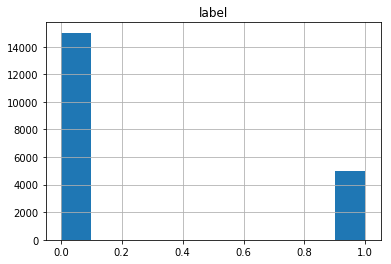

In [375]:
# Let's view the distribution of Labels
labels.hist(['label'])
plt.show()

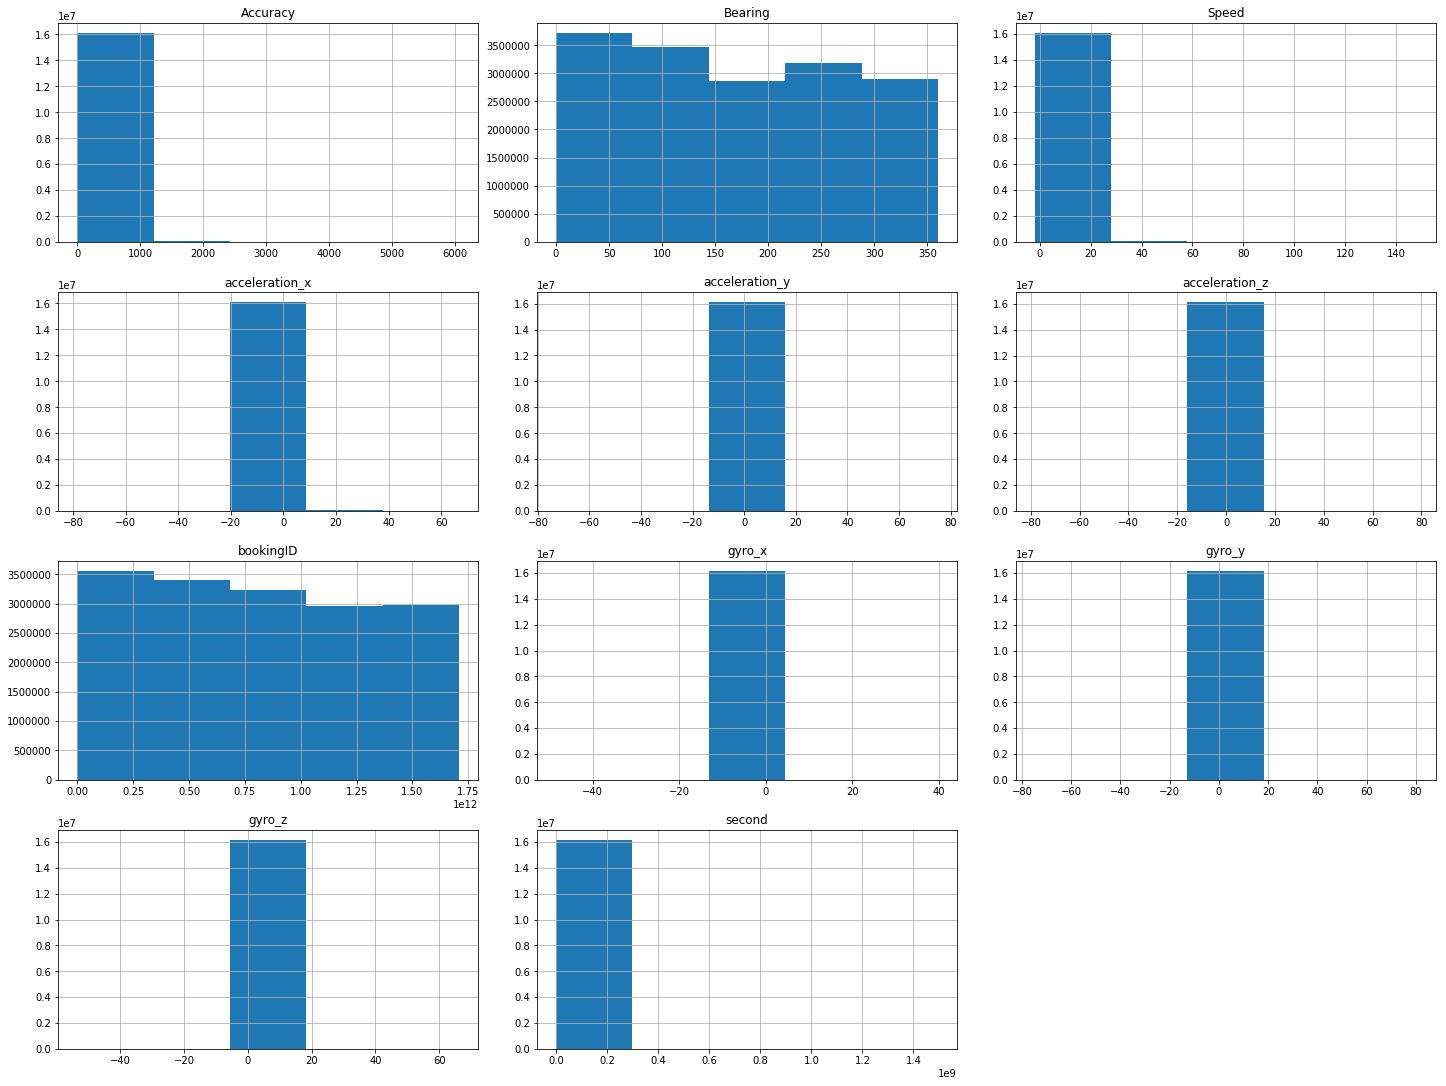

In [376]:
#Checking Distribution of the train set
train.hist(bins=5, figsize=(20,15))
plt.tight_layout(pad=0.4)
plt.show()

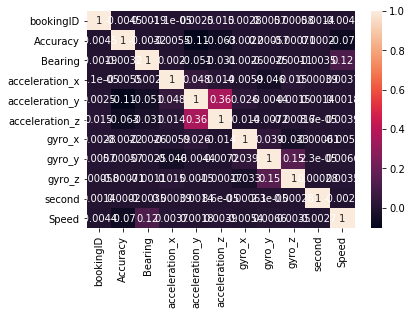

In [377]:
# Check correlation between the features
sns.heatmap(train.corr(), annot = True)

There is little to no correlation between the features. We have to add features in order to extract meaningful predictions.

# Feature Engineering

First off we are going to join the Hold out and Train Data sets for Feature Engineering.

In [338]:
# # Joining the two data sets.
# # We first obtain the Indexes of the test set.
# ids = test.bookingID.unique()

# # Now we join the two data sets
# train = train.append(test, ignore_index=True)

# #Now we join the labels files

# new_labels = pd.concat(new_labels,t_labels,ignore_index = True, sort=False) 

Here we remove erroneous and impractical datapoints.

## Filtering

In [339]:
#Filtering out Inaccurate readings
train = train [train ['Accuracy'] <= 50]
train.reset_index(drop=True, inplace=True)

In [340]:
#Filter Too fast speed and any negative
train = train [(train ['Speed'] > 0) & (train ['Speed'] <= 55)]
train.reset_index(drop=True, inplace=True)

In [341]:
#Filter out Long trips
temp = pd.DataFrame(train.groupby('bookingID').second.max())
trips = temp[(temp['second'] <= 14400)]

train = train[train['bookingID'].isin(trips.index.values)]

Data that is normalized works best with models therefore we will normalize the data before we begin creating features.

In [343]:
#Normalize data before further processing
columns_to_norm = train.drop(['bookingID'], axis=1).columns
train[columns_to_norm] = MinMaxScaler().fit_transform(train[columns_to_norm])

Our Model now needs additional features to give us the best results. Looking at the dataset, these are the features I thought would help out.

This is calculated by the Euclidean distance formula.

In [344]:
train ['Resultant Acceleration'] = np.sqrt ((train['acceleration_x'])**2 + (train['acceleration_y'])**2 + (train['acceleration_z'])**2)

This is also calculated by the Euclidean distance formula.

In [345]:
train ['Resultant gyro'] = np.sqrt ((train['gyro_x'])**2 + (train['gyro_y'])**2 + (train['gyro_z'])**2)

This is the product of the two features.

In [346]:
train ['Resultant Acc & Gyro'] = train ['Resultant Acceleration'] * train ['Resultant gyro']

We now dont need the values so we are going to drop them.

In [347]:
columns_to_drop = ['acceleration_x','acceleration_y','acceleration_z','gyro_x','gyro_y','gyro_z']
train.drop(columns_to_drop, axis = 1, inplace = True)

## Feature transformation
I'm creating additional features by combining the mean,std,min,max,sum,mad and var of every trip.

In [348]:
df_mean = train.groupby('bookingID').mean()
df_std = train.groupby('bookingID').std()
df_min = train.groupby('bookingID').min()
df_max = train.groupby('bookingID').max()
df_sum = train.groupby('bookingID').sum()
df_mad = train.groupby('bookingID').mad()
df_var = train.groupby('bookingID').var()
df_1 = pd.merge(df_mean, df_std, on = 'bookingID', how = 'inner')
df_2 = pd.merge(df_min, df_max, on = 'bookingID', how = 'inner')
df_3 = pd.merge(df_sum, df_mad, on = 'bookingID', how = 'inner')
df_4 = pd.merge(df_1, df_2, on = 'bookingID', how = 'inner')
df_5 = pd.merge(df_4, df_3, on = 'bookingID', how = 'inner')
train_df = pd.merge(df_5, df_var, on = 'bookingID', how = 'inner')

Now we drop any row that has a missing value.

In [349]:
train_df = train_df.dropna()

Using the Transformations, we can create two more features.

In [350]:
train_df['Total Distance'] = df_mean['Speed'] * df_max['second']

train_df['Velocity'] = np.sqrt( 2 * df_mean['Resultant Acceleration'] * train_df['Total Distance'] )

We are done with feature engineering. Now we merge our data with the labels for modeling, removing any that has no label.

In [351]:
#Merge Train data with Labels
train = pd.merge(train_df, new_labels, on = 'bookingID', how = 'inner')

In [352]:
# #Merge Test data with Test Labels
# test = pd.merge(test, new_labels, on = 'bookingID', how = 'inner')

We earlier noticed that our labels are not evenly distributed.But because AUC is insensitive to imbalanced data we will not balance it.

In [353]:
# #Balancing Dangerous with Non-dangerous flags in Dataset
# dangerous = train[train['label'] == 1]
# safe = train[train['label'] == 0]
# safe_sample = safe.sample(len(dangerous), axis = 0)
# balanced = pd.concat([dangerous,safe_sample],axis=0)

In [354]:
# # We split our training and test set back.
# train_df = train[~train['bookingID'].isin(ids)]
# test_df = train[train['bookingID'].isin(ids)]

Last Check before we use the data for modeling.

In [355]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19952 entries, 0 to 19951
Data columns (total 53 columns):
bookingID                     19952 non-null int64
Accuracy_x_x                  19952 non-null float64
Bearing_x_x                   19952 non-null float64
second_x_x                    19952 non-null float64
Speed_x_x                     19952 non-null float64
Resultant Acceleration_x_x    19952 non-null float64
Resultant gyro_x_x            19952 non-null float64
Resultant Acc & Gyro_x_x      19952 non-null float64
Accuracy_y_x                  19952 non-null float64
Bearing_y_x                   19952 non-null float64
second_y_x                    19952 non-null float64
Speed_y_x                     19952 non-null float64
Resultant Acceleration_y_x    19952 non-null float64
Resultant gyro_y_x            19952 non-null float64
Resultant Acc & Gyro_y_x      19952 non-null float64
Accuracy_x_y                  19952 non-null float64
Bearing_x_y                   19952 non-null 

# Modeling

## Train the model 

We use the following Models:
RandomForestClassifier, GradientBoostingClassifier, LogisticRegression, GaussianNB and XGBClassifier

We use stacking to see whether the scores will improve.

We define the Training and Test Data

In [356]:
# X_train = train_df.drop(['bookingID','label'],axis =1)
# y_train = train_df['label']

# X_test = test_df.drop(['bookingID','label'],axis =1)
# y_test = test_df['label']

In [357]:
X = train.drop(['bookingID','label'],axis =1)
y = train['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 101)

## Let's set up the Models

In [358]:
rf = RandomForestClassifier(random_state=53, n_jobs=-1, 
                           n_estimators=100, max_depth=3)
gbc = GradientBoostingClassifier (random_state=53,n_estimators=100,learning_rate=0.05)
log = LogisticRegression(random_state=53,n_jobs=-1)
gnb = GaussianNB()
models = [rf,gbc,log,gnb]
S_train, S_test = stacking(models,X_train, y_train, X_test,   
                           regression=False,mode='oof_pred_bag',needs_proba=False,
                           metric=metrics.roc_auc_score,n_folds=4,stratified=True,
                           shuffle=True,random_state=41)

C:\Users\Andrew Mark\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Users\Andrew Mark\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Users\Andrew Mark\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Users\Andrew Mark\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


## Let's plot the ROC Curve and see how our models perform.

C:\Users\Andrew Mark\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Andrew Mark\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Users\Andrew Mark\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


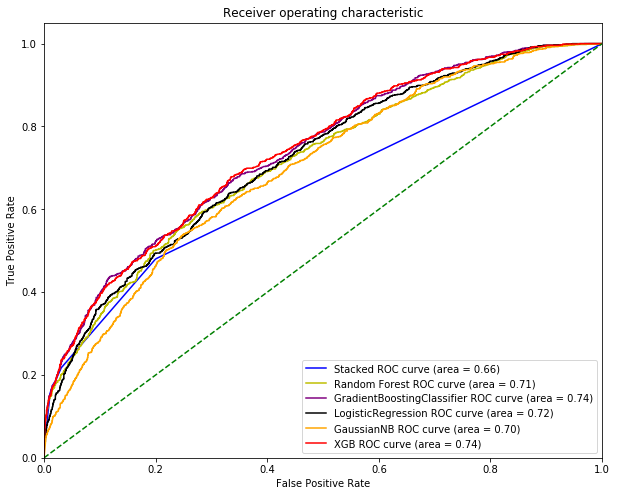

In [359]:
plt.figure(figsize=(10, 8))

model = xgb.XGBClassifier (random_state=53, n_jobs=-1, learning_rate=0.05,n_estimators=100, max_depth=4)
model.fit(S_train,y_train)
y_pred = model.predict(S_test)
pred = model.predict_proba(S_test)[:,1]
stacked_acc = metrics.accuracy_score (y_test,y_pred)
stacked_auc = metrics.roc_auc_score(y_test,pred)
fpr, tpr, _ = metrics.roc_curve(y_test, pred)
plt.plot(fpr, tpr, color='b', label='Stacked ROC curve (area = %0.2f)' % stacked_auc)

#RandomForest
models[0].fit(X_train,y_train)
pred = models[0].predict_proba(X_test)[:,1]
rf_acc = metrics.accuracy_score (y_test,y_pred)
rf_auc = metrics.roc_auc_score(y_test,pred)
fpr, tpr, _ = metrics.roc_curve(y_test, pred)
plt.plot(fpr, tpr, color='y', label='Random Forest ROC curve (area = %0.2f)' % rf_auc)

#GradientBoostingClassifier
models[1].fit(X_train,y_train)
pred = models[1].predict_proba(X_test)[:,1]
gbc_acc = metrics.accuracy_score (y_test,y_pred)
gbc_auc = metrics.roc_auc_score(y_test,pred)
fpr, tpr, _ = metrics.roc_curve(y_test, pred)
plt.plot(fpr, tpr, color='purple', label='GradientBoostingClassifier ROC curve (area = %0.2f)' % gbc_auc)

#LogisticRegression
models[2].fit(X_train,y_train)
pred = models[2].predict_proba(X_test)[:,1]
log_acc = metrics.accuracy_score (y_test,y_pred)
log_auc = metrics.roc_auc_score(y_test,pred)
fpr, tpr, _ = metrics.roc_curve(y_test, pred)
plt.plot(fpr, tpr, color='black', label='LogisticRegression ROC curve (area = %0.2f)' % log_auc)

#GaussianNB
models[3].fit(X_train,y_train)
pred = models[3].predict_proba(X_test)[:,1]
gnb_acc = metrics.accuracy_score (y_test,y_pred)
gnb_auc = metrics.roc_auc_score(y_test,pred)
fpr, tpr, _ = metrics.roc_curve(y_test, pred)
plt.plot(fpr, tpr, color='orange', label='GaussianNB ROC curve (area = %0.2f)' % gnb_auc)

#XGb
model = xgb.XGBClassifier (random_state=53, n_jobs=-1, learning_rate=0.05, 
                  n_estimators=100, max_depth=4)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
pred = y_prob[:,1]
xgb_acc = metrics.accuracy_score (y_test,y_pred)
xgb_auc = metrics.roc_auc_score(y_test,pred)
fpr, tpr, _ = metrics.roc_curve(y_test, pred)
plt.plot(fpr, tpr, color='r', label='XGB ROC curve (area = %0.2f)' % xgb_auc)


plt.plot([0, 1], [0, 1], color='g', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')

plt.legend(loc=0)

# OUR EVALUATION

In [360]:
print(' Model Accuracy : \t\t', xgb_acc)
print(' Model AUC \t\t\t', xgb_auc)

 Model Accuracy : 		 0.7867702330243047
 Model AUC 			 0.7401385204029436


In [361]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.79      0.98      0.87      3020
          1       0.74      0.19      0.31       971

avg / total       0.78      0.79      0.74      3991



In [362]:
print(confusion_matrix(y_test, y_pred))

[[2953   67]
 [ 784  187]]
